In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula, StudentTCopula_Likelihood
#from bvcopula import MixtureCopula, MixtureCopula_Likelihood
from bvcopula import GPInferenceModel, KISS_GPInferenceModel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [28]:
import pickle as pkl
import numpy as np

animal = 'ST263'
day_name = 'Day4'
path = '/home/nina/GPyTorch/LFI/data_scan/{}'.format(day_name.lower())

counters = np.zeros(5)
orients = np.zeros(4)

names = ['Gaussian','Frank','Clayton','Gumbel']
orientations = ['0°', '90°', '180°', '270°']

for i in range(-5,22,1):
    for j in range(i+1,23,1):
        try:
            with open("{}/{}_{}_{}-{}_best.pkl".format(path,animal,day_name,i,j),'rb') as f:
                res = pkl.load(f)
            #print(res['copulas'])
            if len(res['copulas'])==0:
                counters[-1] += 1
            else:
                for copula in res['copulas']:
                    for n, name in enumerate(names):
                        if copula[0] == name:
                            counters[n] += 1
                    for o, orient in enumerate(orientations):
                        if copula[1] == orient:
                            orients[o] += 1
        except FileNotFoundError as error:
            print(i,j)
print(100*counters/np.sum(counters))
print(100*orients/np.sum(orients))

percent = np.round(100*counters/np.sum(counters[:-1]))

-5 -3
-4 -3
0 20
0 22
1 21
6 8
6 14
7 15
9 15
9 21
11 22
13 20
14 16
14 20
19 22
[ 6.99300699 20.1048951  41.60839161  4.54545455 26.74825175]
[22.72727273 18.93939394 41.28787879 17.04545455]


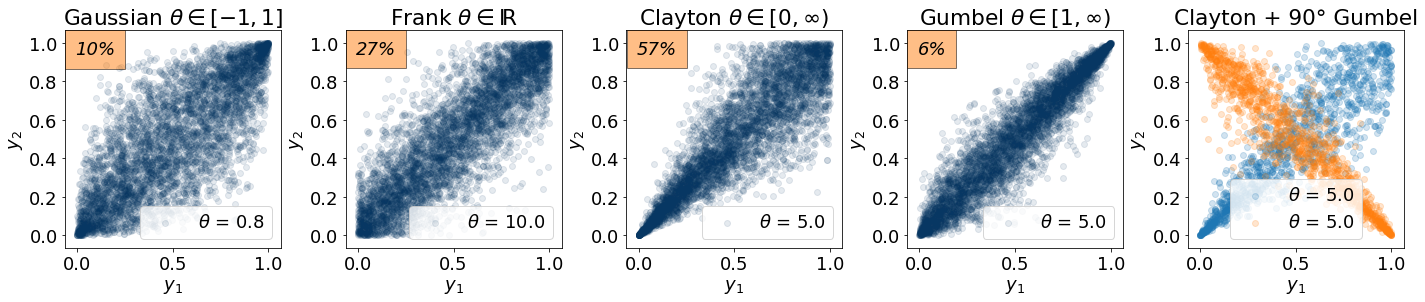

In [30]:
# here we generate some synthetic samples
import matplotlib.cm as cm

NSamp = int(5000)
color='#073763ff'

X = np.linspace(0.,1.,NSamp) 

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1,5,figsize=(24,4.0))

model = GaussianCopula(torch.ones(NSamp).float()*0.8)
Y = model.sample().numpy().squeeze()
ax[0].scatter(*Y.T, color=color, alpha=0.1, label=r'$\theta$ = 0.8')# color=colors)
ax[0].set_xlabel('$y_1$')
ax[0].set_ylabel('$y_2$')
ax[0].set_title(r'Gaussian $\theta \in [-1,1]$')
ax[0].legend(loc=4)

model = FrankCopula(torch.ones(NSamp).float()*10.0)
Y = model.sample().numpy().squeeze()
ax[1].scatter(*Y.T, color=color, alpha=0.1, label=r'$\theta$ = 10.0')# color=colors)
ax[1].set_xlabel('$y_1$')
ax[1].set_ylabel('$y_2$')
ax[1].set_title(r'Frank $\theta \in {\rm I\!R}$')
ax[1].legend(loc=4)

model = ClaytonCopula(torch.ones(NSamp).float()*5.0, rotation='0°')
Y = model.sample().numpy().squeeze()
ax[2].scatter(*Y.T, color=color, alpha=0.1, label=r'$\theta$ = 5.0')# color=colors)
ax[2].set_xlabel('$y_1$')
ax[2].set_ylabel('$y_2$')
ax[2].set_title(r'Clayton $\theta \in [0,\infty)$')
ax[2].legend(loc=4)

model = GumbelCopula(torch.ones(NSamp).float()*5.0, rotation='0°')
Y = model.sample().numpy().squeeze()
ax[3].scatter(*Y.T, color=color, alpha=0.1, label=r'$\theta$ = 5.0')# color=colors)
ax[3].set_xlabel('$y_1$')
ax[3].set_ylabel('$y_2$')
ax[3].set_title(r'Gumbel $\theta \in [1,\infty)$')
ax[3].legend(loc=4)

for i in range(4):
    sh = 0
    ax[i].text(-.01, 0.94+sh, "{:.0f}%".format(percent[i]), style='italic',
        bbox={'facecolor': 'C1', 'alpha': 0.5, 'pad': 10})

for r,c,C in zip(['0°','90°'],['C0','C1'],[ClaytonCopula,GumbelCopula]):
    model = C(torch.ones(int(NSamp/4)).float()*5.0, rotation=r)
    Y = model.sample().numpy().squeeze()
    ax[4].scatter(*Y.T, color=c, alpha=0.2, label=r'$\theta$ = 5.0')# color=colors)
ax[4].set_xlabel('$y_1$')
ax[4].set_ylabel('$y_2$')
ax[4].set_title('Clayton + 90° Gumbel')
ax[4].legend()

plt.subplots_adjust(wspace=0.3)

plt.savefig('poster_img/families.svg')
#fig.show()

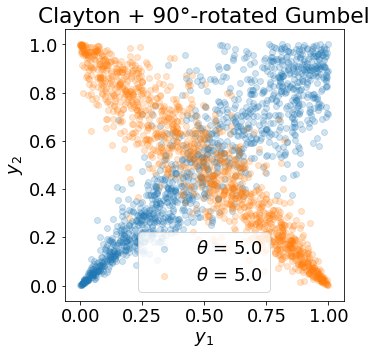

In [4]:
fig = plt.figure(figsize=(5,5))

for r,c,C in zip(['0°','90°'],['C0','C1'],[ClaytonCopula,GumbelCopula]):
    model = C(torch.ones(int(NSamp/4)).float()*5.0, rotation=r)
    Y = model.sample().numpy().squeeze()
    plt.scatter(*Y.T, color=c, alpha=0.2, label=r'$\theta$ = 5.0')# color=colors)
plt.xlabel('$y_1$')
plt.ylabel('$y_2$')
plt.title('Clayton + 90°-rotated Gumbel')
plt.legend()

In [5]:
class sfg():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #/questions/110685/matplotlib-can-i-create-axessubplot-objects-then-add-them-to-a-figure-instance/689918#689918
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

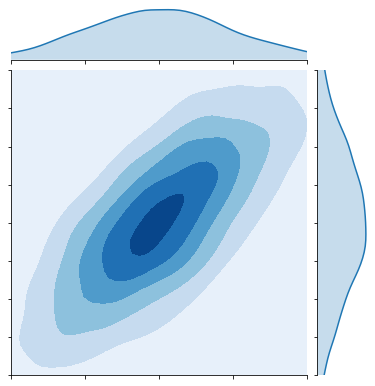

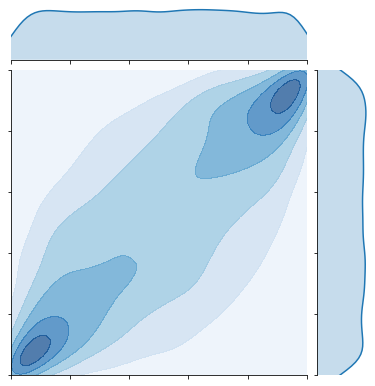

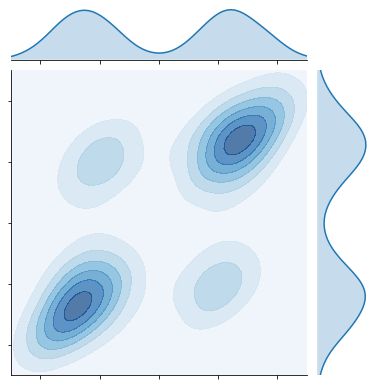

In [31]:
# here we generate some synthetic samples
import matplotlib.cm as cm
from scipy.stats import norm
import seaborn as sns
import matplotlib.gridspec as gridspec

NSamp = int(1e4)
color='#073763ff'

X = np.linspace(0.,1.,NSamp) 

plt.rcParams.update({'font.size': 18})

model = GaussianCopula(torch.ones(NSamp).float()*(0.7))
Y = model.sample().numpy().squeeze()
Y_unimodal = norm.ppf(Y)
Y_bimodal = np.empty_like(Y)
Y_bimodal[Y>0.5] = norm.ppf(2*Y[Y>0.5]-1.)+2.5
Y_bimodal[Y<=0.5] = norm.ppf(2*Y[Y<=0.5])-2.5

gs = gridspec.GridSpec(1,3)

#cmap = 'Blues'
g0 = sns.jointplot(*Y_unimodal.T, kind="kde", shade=True,  shade_lowest=True, joint_kws = dict(cmap='Blues'), n_levels=6)#, cmap=cmap)
g1 = sns.jointplot(*Y.T, kind="kde", shade=True,  shade_lowest=True, joint_kws = dict(alpha=0.7, cmap='Blues'), n_levels=6)#, cmap=cmap)
g2 = sns.jointplot(*Y_bimodal.T, kind="kde", shade=True,  shade_lowest=True, joint_kws = dict(alpha=0.7, cmap='Blues'), n_levels=6)#, cmap=cmap)

g0.ax_marg_x.set_xlim(-2, 2)
g0.ax_marg_y.set_ylim(-2, 2)
g0.ax_marg_x.set_xticklabels([])
g0.ax_marg_y.set_yticklabels([])

g1.ax_marg_x.set_xlim(0, 1)
g1.ax_marg_y.set_ylim(0, 1)
g1.ax_marg_x.set_xticklabels([])
g1.ax_marg_y.set_yticklabels([])

g2.ax_marg_x.set_xlim(-5, 5)
g2.ax_marg_y.set_ylim(-5, 5)
g2.ax_marg_x.set_xticklabels([])
g2.ax_marg_y.set_yticklabels([])

plt.axis("off")

# g0.savefig('poster_img/intro1.svg')
# g1.savefig('poster_img/intro0.svg')
# g2.savefig('poster_img/intro2.svg')

# mg0 = sfg.SeabornFig2Grid(g0, fig, gs[0])
# mg1 = sfg.SeabornFig2Grid(g1, fig, gs[1])
# mg2 = sfg.SeabornFig2Grid(g2, fig, gs[2])

# gs.tight_layout(fig)

# plt.show()

In [20]:
cp = sns.color_palette()

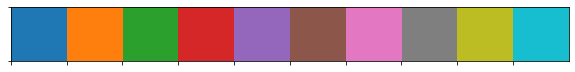

In [21]:
sns.palplot(cp)